# Sock Matching Algorithm Project

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from rembg import remove
from tqdm import tqdm
from PIL import Image
from collections import deque

/usr/lib/python3/dist-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Original Image

In [6]:
def displaySample(path, imgCnt=10, seed=42):
    fileInPath = os.listdir(path)
    random.seed(seed)

    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))

    # Display the images
    for i in range(imgCnt):
        img = mpimg.imread(path + random.choice(fileInPath))
        ax = fig.add_subplot(1, imgCnt, i + 1)
        ax.imshow(img)
        ax.axis('off')

    plt.show()

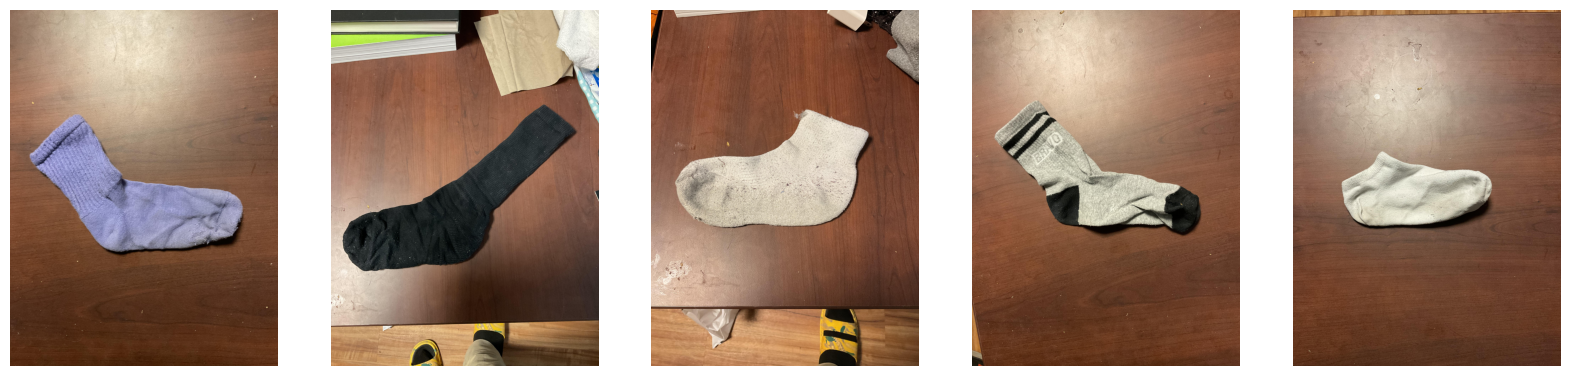

In [239]:
displaySample("./JPG/", 5)

## 1. Preprocessing

In [201]:
# Create folders for the images
if not os.path.exists("./JPG/"):
    os.makedirs("./JPG/")

if not os.path.exists("./Resized/"):
    os.makedirs("./Resized/")

if not os.path.exists("./RemBg/"):
    os.makedirs("./RemBg/")
    
if not os.path.exists("./Centered/"):
    os.makedirs("./Centered/")

### 1.1. Resizing Images

In [205]:
def resize(path, output, size=(512, 512)):
    fileInPath = os.listdir(path)

    for file in tqdm(fileInPath):
        outputPath = output + file
        if not os.path.exists(outputPath):
          img = cv2.imread(path + file)
          img = cv2.resize(img, size)
          cv2.imwrite(outputPath, img)

In [206]:
resize("./JPG/", "./Resized/")

100%|██████████| 49/49 [00:14<00:00,  3.38it/s]


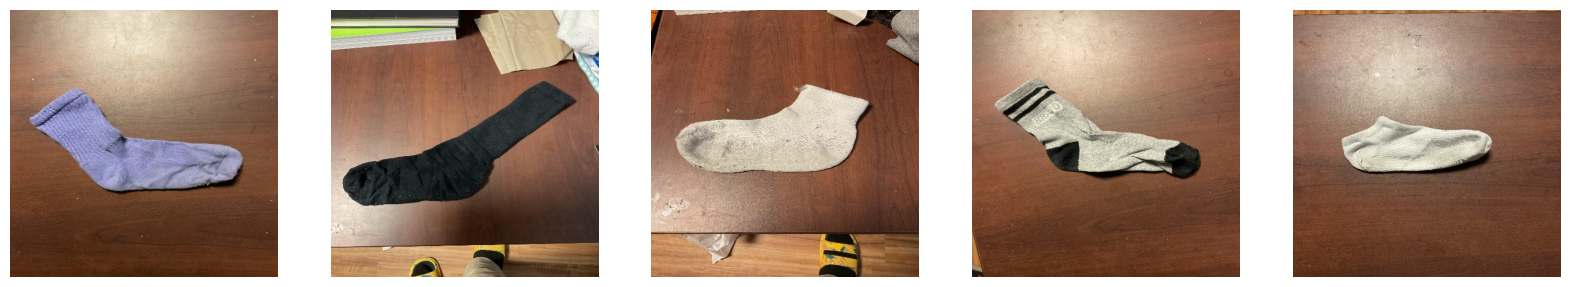

In [240]:
displaySample("./Resized/", 5)

### 1.1. Removing Background and saving the images

In [207]:
def removeBg(path): 
  # TODO: Have a cross on the app 

  files = os.listdir(path)

  for file in tqdm(files):
    if file.endswith(".jpg"):
      input_path = os.path.join(path, file)
      output_path = os.path.join("./RemBg/", file)
    
      if not os.path.exists(output_path):
        # tqdm.write("Removing background from image: " + file)

        # Saving the image with removed background
        input_array = np.array(Image.open(input_path))
        result = remove(input_array)
        img = Image.fromarray(result).convert("RGB")
        img.save(output_path)
        
        # Removing the original image
        # os.remove(input_path)
      
      

In [209]:
removeBg("./Resized/")

100%|██████████| 49/49 [02:43<00:00,  3.34s/it]


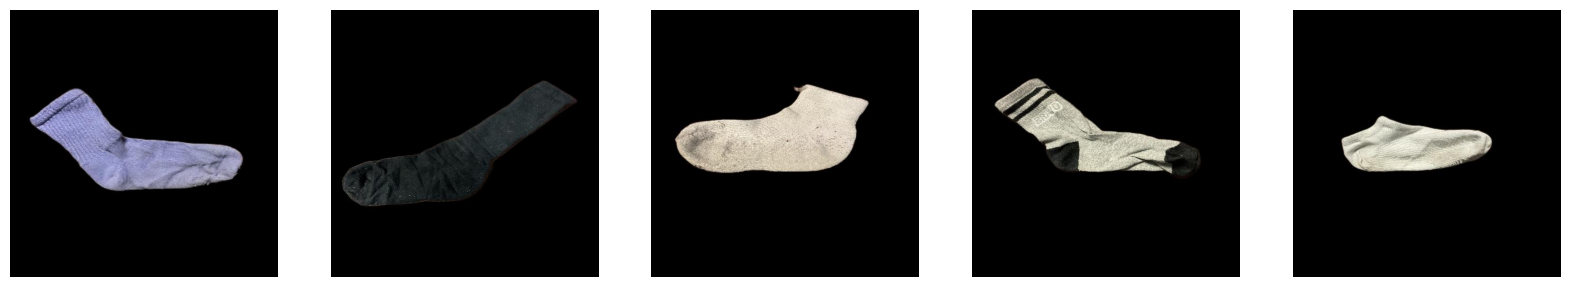

In [241]:
displaySample("./RemBg/", 5)

### 1.2. Centering the images

#### 1.2.1.  By removing the black rows / cols from all 4 sides

In [210]:
def isArrayBlack(arr):
  THRESHOLD = 0.03 # If 95% of the array is black, then it is black
  cnt = np.count_nonzero(np.count_nonzero(arr != [0, 0, 0], axis=1))
  # print(cnt, len(arr) * THRESHOLD, len(arr))
  return cnt < len(arr) * THRESHOLD

def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)

  np_img = np.array(img)

  # Remove rows / cols with only black pixels

  top = 0
  for i in range(np_img.shape[0]):
    row = np_img[i]
    if not isArrayBlack(row):
      top = i
      break
  
  bottom = len(np_img)
  for i in range(np_img.shape[0] - 1, 0, -1):
    row = np_img[i]
    if not isArrayBlack(row):
      bottom = i
      break
  
  left = 0
  for i in range(np_img.shape[1]):
    col = np_img[:, i]
    if not isArrayBlack(col):
      left = i
      break
  
  right = len(np_img[1])
  for i in range(np_img.shape[1] - 1, 0, -1):
    col = np_img[:, i]
    if not isArrayBlack(col):
      right = i
      break

  # Crop the image
  np_img = np_img[top:bottom, left:right]

  # Save the image
  cv2.imwrite(newPath, np_img)

  # Remove the original image
  # os.remove(imgPath)

#### 1.2.2. By assuming the center of the image is part of the image and BFS out farther till we find a black pixel
- Issue with this could be time complexity

In [2]:
def centerImage(imgPath, newPath):
  img = cv2.imread(imgPath)
  img = cv2.resize(img, (512, 512))
  np_img = np.array(img)

  center_img = np.array([np_img.shape[0] // 2, np_img.shape[1] // 2])

  pixel_queue = deque([center_img])
  visited = {}
  
  top = float("inf")
  bottom = -1
  left = float("inf")
  right = -1

  firstTime = True

  while pixel_queue:
    pixel = pixel_queue.popleft()
    if visited.get(str(pixel)) == True:
      continue

    visited[str(pixel)] = True

    if firstTime or np_img[pixel[0]][pixel[1]][0] != 0 or np_img[pixel[0]][pixel[1]][1] != 0 or np_img[pixel[0]][pixel[1]][2] != 0:
      firstTime = False
      
      # Findng top, bottom, left, right coordinates
      top  = min(top, pixel[0])
      bottom = max(bottom, pixel[0])
      left = min(left, pixel[1])
      right = max(right, pixel[1])

      # Going to neighboring pixels (up, down, left, right)
      # TODO: For satefy, you could also go to the diagonally neighboring pixels
      pixel_queue.append([pixel[0] - 1, pixel[1]])
      pixel_queue.append([pixel[0] + 1, pixel[1]])
      pixel_queue.append([pixel[0], pixel[1] - 1])
      pixel_queue.append([pixel[0], pixel[1] + 1])

  try:
    # Crop the image
    np_img = np_img[top:bottom, left:right]

    # Resize the image # TODO: May be dont resize it to square, but to rectangle
    result_img = Image.fromarray(np_img)
    result_img = result_img.resize((256, 256))


    # Save the image
    result_img.save(newPath)
  except Exception as e:
    print(f"Image {imgPath} is not centered or something went wrong")
    print(e)

  # Remove the original image
  # os.remove(imgPath)



In [3]:
def centerImages(path, newPath):
  files = os.listdir(path)

  for file in tqdm(files):
    newFilePath = os.path.join(newPath, file)

    if not os.path.exists(newFilePath):
      centerImage(os.path.join(path, file), newFilePath)

In [4]:
centerImages("./RemBg/", "./Centered/")

100%|██████████| 49/49 [01:10<00:00,  1.44s/it]


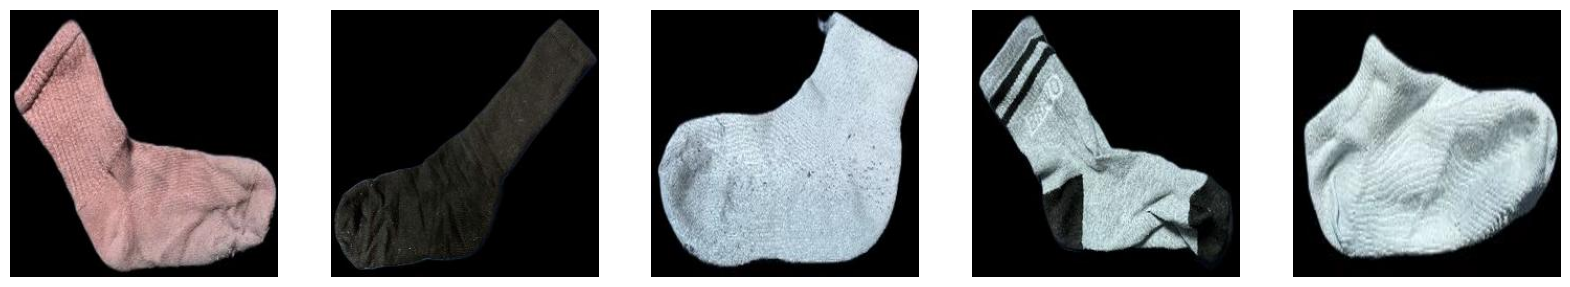

In [7]:
displaySample("./Centered/", 5)